# 2021-10-13 First working draft of a model with looming aversion

Results below are for commit: ### (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

I have now:

* Implemented `oVAL` as described in the SCPaper README. Originally I defined the value as 

$$
-V_{free} \cdot \ln{(\dot{\theta} / \dot{\theta}_0)} / \ln{(\dot{\theta}_1 / \dot{\theta}_0)}
$$

with value zero if $\dot{\theta} \leq \dot{\theta}_0$, and with the logarithm in there based on Kai's findings. However, playing around with it, that meant setting immensely large $\dot{\theta}_1$ for the value to ever fall to only a small fraction of $V_{free}$. Therefore I reformulated it as 

$$
-V_{free} (\dot{\theta} - \dot{\theta}_0) / (\dot{\theta}_1 - \dot{\theta}_0)
$$

at least for now. I have set the default parameter values to $\dot{\theta}_0 = 0.001$ rad/s and $\dot{\theta}_1 = 0.1$ rad/s.

* Removed the "constant speed" from consideration in the `oVAa` case, since my thinking is that `oVAl` would fill the same role.

# Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
from sc_scenario import get_default_params, get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework


## Unit tests, reproducing earlier results

The addition of `oVAl` definitely shouldn't affect these, but just double checking to be safe - and all seems fine.

Just the base model, no interaction. 

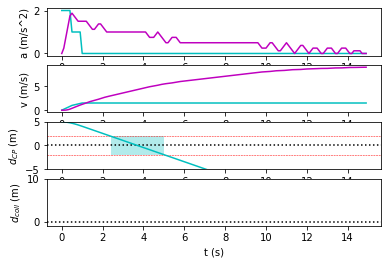

In [2]:
NAMES = ('P', 'V')
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

Baseline kinematics, base model. 

Initial car distance 30 m:


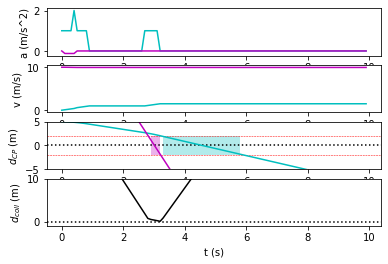

Initial car distance 40 m:


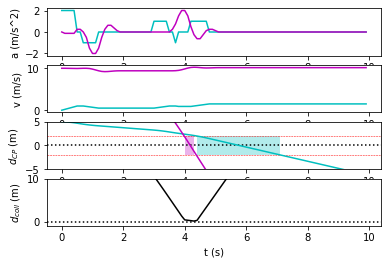

Initial car distance 50 m:


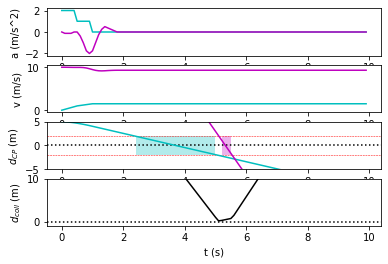

In [3]:
SPEEDS = np.array((0, 10))
EFF_WIDTHS = (0.8, 1.8)
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), plot_beh_probs = False, 
                            plot_beh_activs = False, plot_beh_accs = False,
                            plot_looming = False, ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = SCSimulation(
                CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps), eff_widths = EFF_WIDTHS)
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              looming = plot_looming)

run_baseline_kinematics()

## Impact of looming aversion

### Adding just `oVAl` does have an effect

Adding just `oVAl` to the base `oVA` model does change the behaviour compared to above. What seems to be happening here is that the pedestrian does not initially try to pass in front of the car like it does in the base model above, presumably because this exposes the pedestrian to some visual looming.

Initial car distance 40 m:


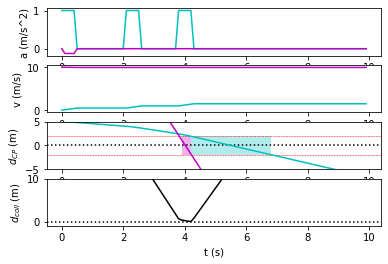

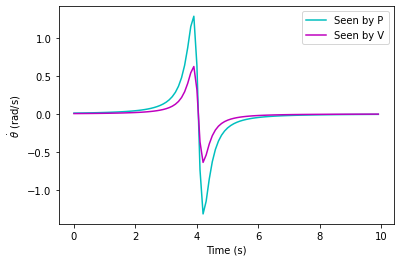

In [4]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oVAl = True)
run_baseline_kinematics(dist0s=(40,), plot_looming=True)

### Combining with `oVAa` and `oBEo` - looming aversion does counteract the collision-proneness of `oVAa`

Below we can see that when we turn on `oBEo` together with `oVAa`, for the current default parameters we get the previously noted collision problem for `oVAa` if not considering the "constant speed" behaviour as a possibility (as mentioned at the top, I turned that off now). And as I hoped, adding in `oVAl` does solve that specific problem. (Running the same as below, but with `oBEv` instead of `oBEv` produces quite similar results.)

oVAl = False
Initial car distance 40 m:


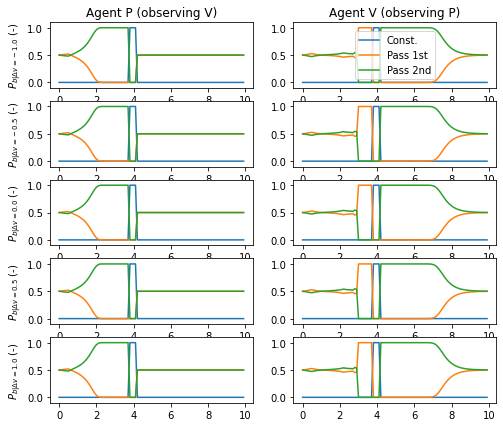

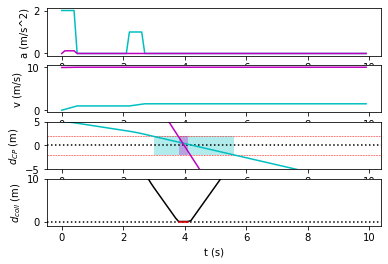

oVAl = True
Initial car distance 40 m:


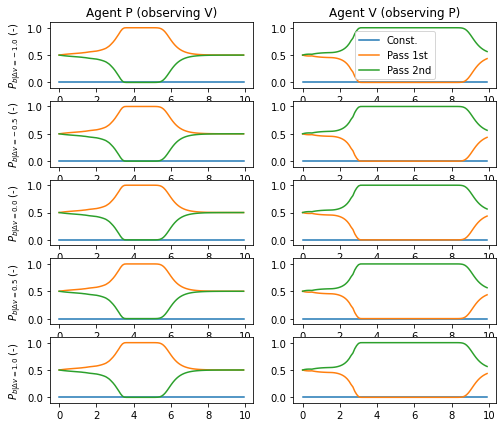

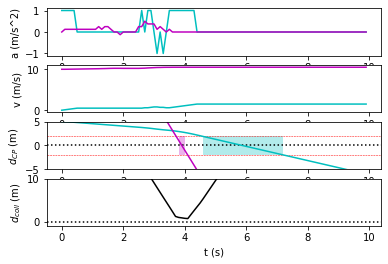

In [5]:
for oVAl in (False, True):
    print(f'oVAl = {oVAl}')
    optional_assumptions = get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oVAa = True, oBEo = True, oVAl = oVAl)
    run_baseline_kinematics(dist0s=(40,), plot_beh_probs = True)

### Effect of looming aversion on priority assertion - mixed news

Below replicating the same priority aversion that I have noted before for this baseline scenario, with the `oVAoBEooBEvoAI` model. Adding `oVAl` removes (or at least massively reduces) the acceleration, making the results more similar to the base model + `oVAl` simulation above, where the pedestrian quickly accepts that it's passing in second. Not clear though whether this will be a general phenomenon of this model, or whether there are parameterisations which would still show priority assertion.

Out of interest doing the same below also with `oVAa` in the mix. Again getting a collision, which gets sorted when adding in `oVAl`, and there is actually a bit more of an acceleration from the vehicle in this scenario compared to the non-`oVAa` counterpart.

*** oVAa = False
	--- oVAl = False
Initial car distance 40 m:


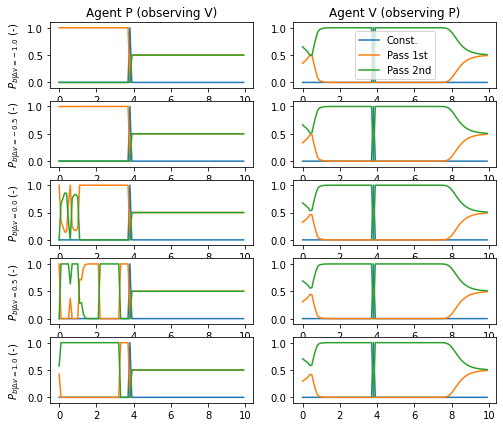

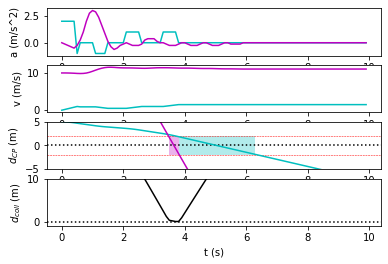

	--- oVAl = True
Initial car distance 40 m:


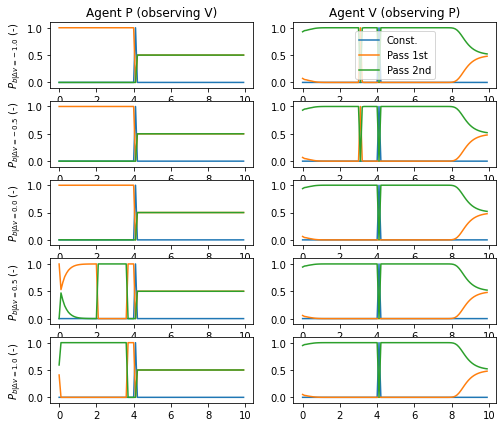

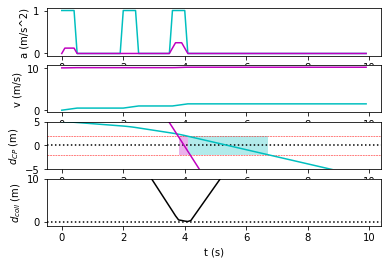

*** oVAa = True
	--- oVAl = False
Initial car distance 40 m:


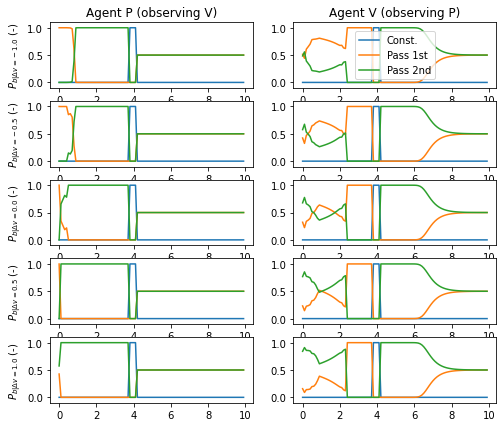

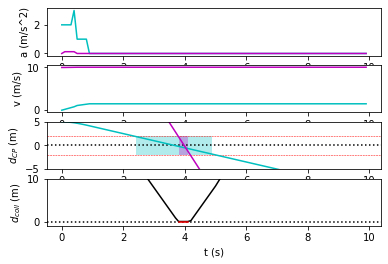

	--- oVAl = True
Initial car distance 40 m:


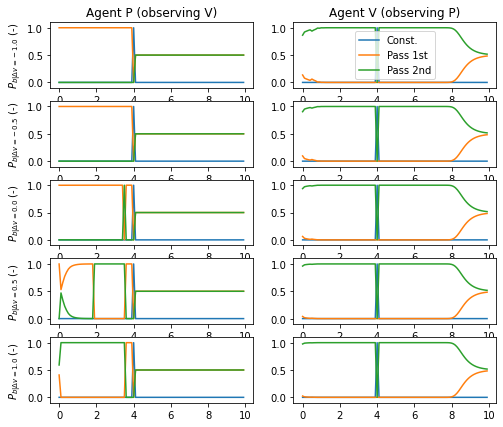

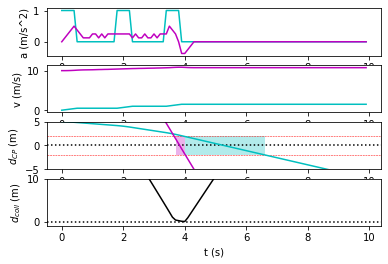

In [6]:
for oVAa in (False, True):
    print(f'*** oVAa = {oVAa}')
    for oVAl in (False, True):
        print(f'\t--- oVAl = {oVAl}')
        optional_assumptions = get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oVAa = oVAa, oBEo = True, oBEv = True, oAI = True, oVAl = oVAl)
        run_baseline_kinematics(dist0s=(40,), plot_beh_probs = True)

### Simplified Keio-like scenario - looking for human-like crossing onset with a yielding car

Below we can see that we get back the same behaviour as before when we turn on both `oVAa` and `oBEo` in a "vehicle yielding" scenario - the pedestrian quickly decides that the car is stopping, and goes ahead and crosses early, which would be quite atypical for humans.

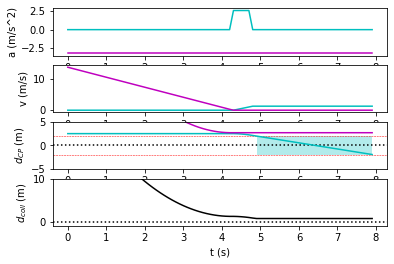

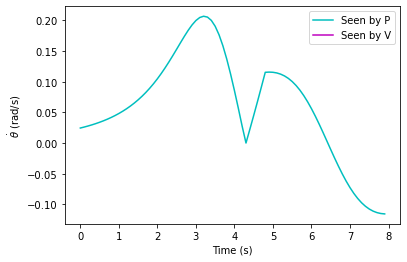

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.


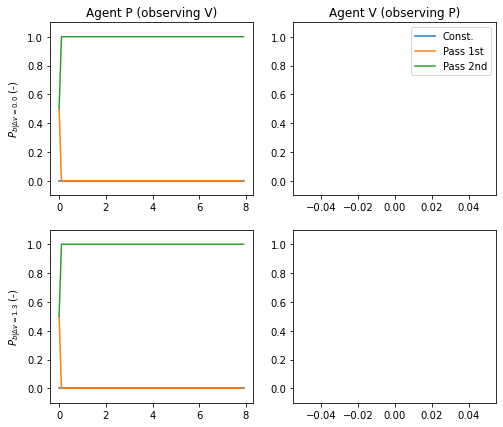

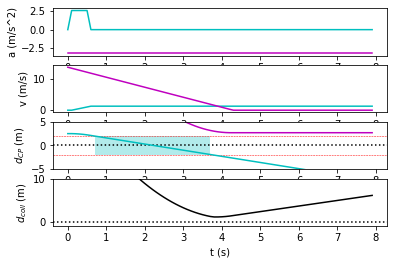

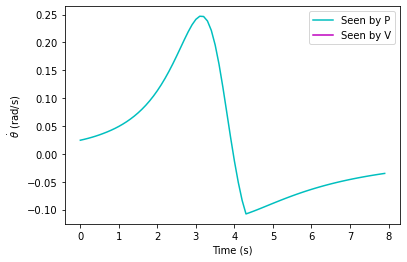

Agent P entered conflict area at t = 0.70 s
Agent V did not enter the conflict area.


In [33]:
import math

def run_keio_scenario(time_step = 0.1, T_P = 0.5, sigma_O = 0.01, thetaDot_1 = 0.1,
                      oVAa = False, oVAl = False, oBEo = False, 
                      plot_beh_probs = False, plot_looming = False,
                      ped_snapshot_times = None):
    INITIAL_POSITIONS = np.array([[0,-2.5], [13.9*2.29, 0]])
    GOALS = np.array([[0, 5], [-50, 0]])
    SPEEDS = np.array((0, 13.9))
    stop_dist = INITIAL_POSITIONS[1][0] - sc_scenario.SHARED_PARAMS.d_C
    CONST_ACCS = (None, -SPEEDS[1] ** 2 / (2 * stop_dist))
    
    # set parameters and optional assumptions
    AFF_VAL_FCN = True
    (params, params_k) = get_default_params(oVA = AFF_VAL_FCN)
    params.ctrl_deltas = np.array([0, 1.3]) # only a single move-forward action
    params.T_P = T_P
    params.T_O = math.inf
    params.sigma_O = sigma_O
    params.thetaDot_1 = thetaDot_1
    optional_assumptions = get_assumptions_dict(default_value = False, oVA = AFF_VAL_FCN,
                                               oVAa = oVAa, oVAl = oVAl, oBEo = oBEo)  

    # run simulation
    SNAPSHOT_TIMES = (ped_snapshot_times, None)
    sc_simulation = SCSimulation(
            CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
            end_time = 8, optional_assumptions = optional_assumptions,
            const_accs = CONST_ACCS, agent_names = NAMES, eff_widths = EFF_WIDTHS,
            params = params, snapshot_times = SNAPSHOT_TIMES, time_step=time_step)
    sc_simulation.run()

    # plot and give some results feedback
    sc_simulation.do_plots(kinem_states=True, beh_probs=plot_beh_probs, looming=plot_looming)
    for agent in sc_simulation.agents:
        ca_entered = np.nonzero(np.linalg.norm(agent.trajectory.pos, axis=0)
                                <= sc_scenario.SHARED_PARAMS.d_C)[0]
        if len(ca_entered) == 0:
            print('Agent %s did not enter the conflict area.' % agent.name)
        else:
            print('Agent %s entered conflict area at t = %.2f s' 
                  % (agent.name, sc_simulation.time_stamps[ca_entered[0]]))
            
            
run_keio_scenario(oVAa=True, oBEo=False, plot_looming=True)
run_keio_scenario(oVAa=True, oBEo=True, plot_beh_probs=True, plot_looming=True)

So the idea here was that what was missing in the model as simulated above was that humans find looming naturally aversive. If so, we could add in `oVAl` to make the model wait until the car was coming closer to a stop, where looming is falling back toward lowever values again, before beginning to cross. 

And indeed, the looming aversion does prevent the early crossing, but it's not necessarily easy to find a parameterisation that does the human-like thing and starts crossing in the last stages of vehicle stopping - as can be seen below, as I try different $\dot{\theta}_1$ with the other parameters at default values, there is a bifurcation between crossing after vehicle stop and crossing early, with no signs of anything in between:


*** thetaDot_1 = 0.1 rad/s


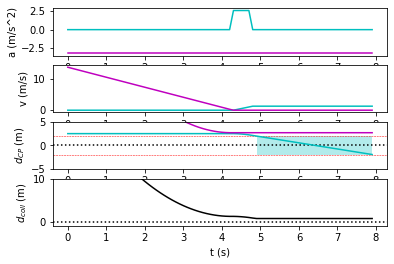

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.

*** thetaDot_1 = 1 rad/s


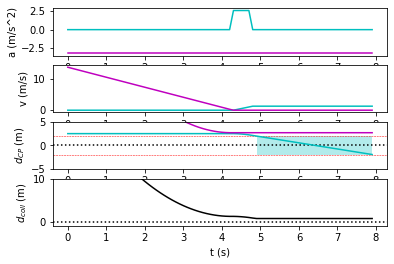

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.

*** thetaDot_1 = 1.6 rad/s


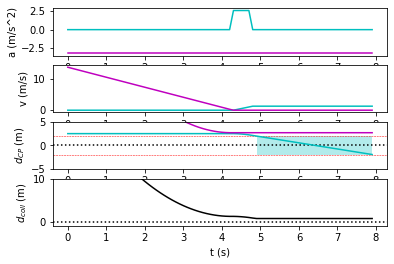

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.

*** thetaDot_1 = 1.65 rad/s


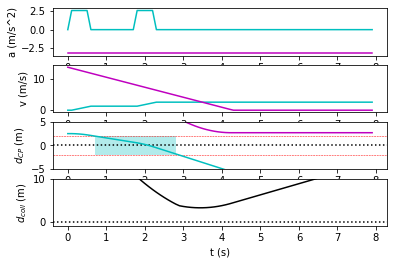

Agent P entered conflict area at t = 0.70 s
Agent V did not enter the conflict area.

*** thetaDot_1 = 2 rad/s


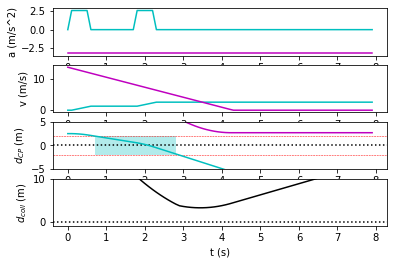

Agent P entered conflict area at t = 0.70 s
Agent V did not enter the conflict area.

*** thetaDot_1 = 5 rad/s


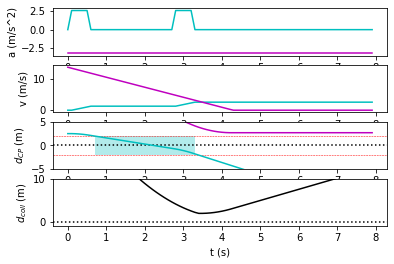

Agent P entered conflict area at t = 0.70 s
Agent V did not enter the conflict area.


In [32]:
for thetaDot_1 in (0.1, 1, 1.6, 1.65, 2, 5):
    print(f'\n*** thetaDot_1 = {thetaDot_1} rad/s')
    run_keio_scenario(oVAa=True, oBEo=True, oVAl=True, thetaDot_1=thetaDot_1)

Another possible culprit here might be how the `oBEo` beliefs change over time. And if I fix $\dot{\theta}_1 = 1.65$ rad/s, the lowest value at which I got early crossings above, and increase $\sigma_O$ from 0.01 m to 0.02 m, to get slower belief buildup, we can see this does indeed prevent the early crossing. But again there is this bifurcation, having the crossing jump all the way to after the vehicle has come to a full stop.


*** sigma_O = 0.01 m


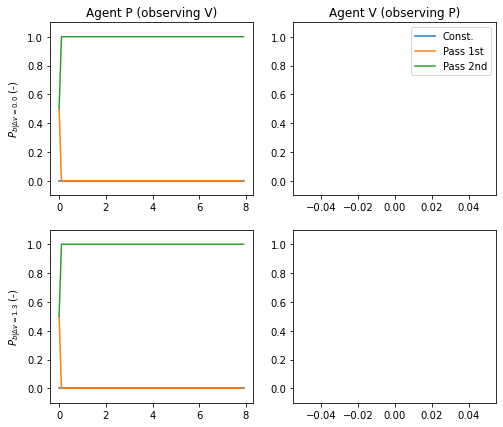

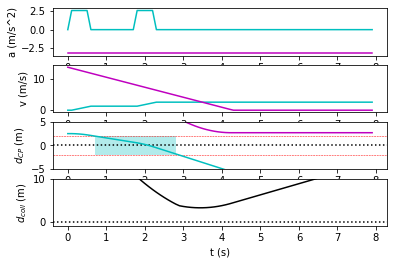

Agent P entered conflict area at t = 0.70 s
Agent V did not enter the conflict area.

*** sigma_O = 0.02 m


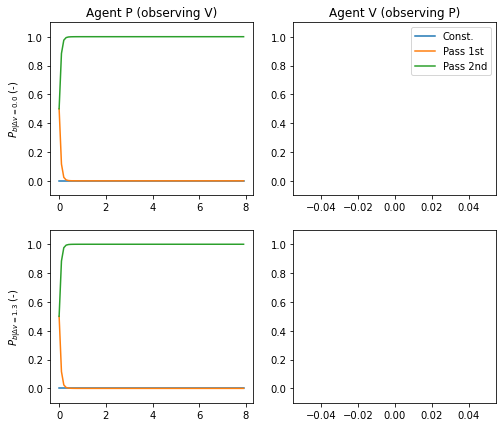

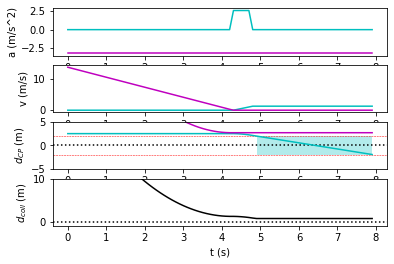

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.


In [48]:
for sigma_O in (0.01, 0.02):
    print(f'\n*** sigma_O = {sigma_O} m')
    run_keio_scenario(oVAa=True, oBEo=True, oVAl=True, thetaDot_1=1.65, sigma_O=sigma_O, plot_beh_probs=True)

Looking more closely at a snapshot at t = 3.8 s in the simulation just above, we can see what is happening. Again, just as observed previously for the non-acceleration-aware `oVA` model, the pedestrian predicts that even if the car is yielding (bottom row of plots), it will still have a non-zero speed at future time point being considered, because the pedestrian assumes the vehicle is yielding to stop *exactly* at the boundary of the conflict space, whereas in fact the vehicle is yielding to stop earlier. So one possible fix here might be that I need to rethink the "pass first / pass second" behaviours, to include some safety margins?

Another thing to notice about `oVAl` as currently implemented, is that the agent can pretend it won't have problems with looming in the future. Note how the value of passing first behind a yielding vehicle after choosing to remain standing for now (bottom left plot) is estimated at 40.40; the pedestrian effectively judges that it will start walking the next time step instead. There is no looming aversion as part of that value calculation, since the looming aversion is currently only considered for the specific future point in time $t + T_p$, not the behaviour beyond that time point, which is an important part of what yields 40.40. Passing first behind a yielding vehicle after having started walking in the current time step (bottom right plot) is estimated to be worth 34.61 instead, because of the aversive looming stimulus. A fix to address this would be much more complicated - it would require something like computing an entire integral (or maximum or something) of looming values over the full prediction horizon. This is not impossible I guess, especially in this simplified SC scenario, but also not entirely easy, and would add a bit more computation...

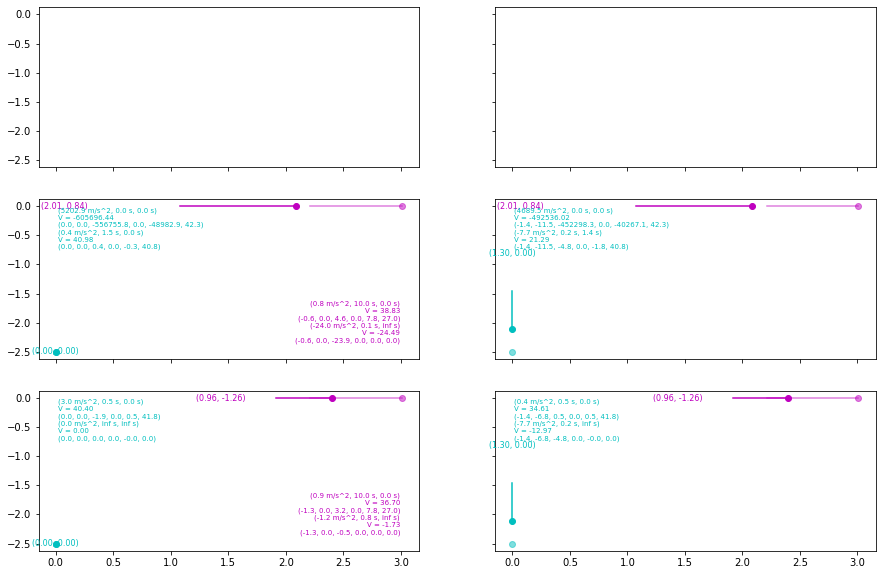

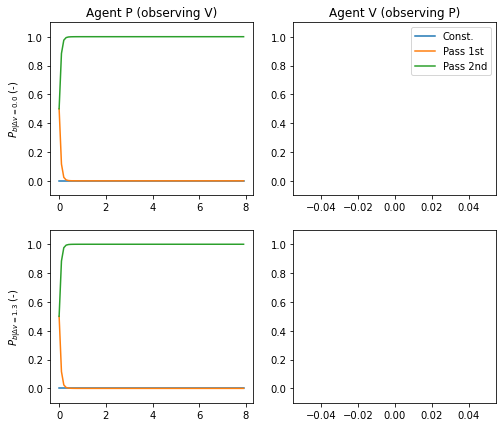

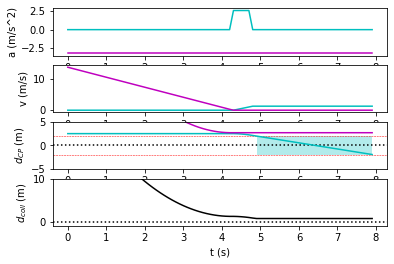

Agent P entered conflict area at t = 4.90 s
Agent V did not enter the conflict area.


In [50]:
run_keio_scenario(oVAa=True, oBEo=True, oVAl=True, thetaDot_1=1.65, sigma_O=0.02, plot_beh_probs=True, ped_snapshot_times=(3.8,))

## Conclusion

I need to think about what to do next, between the two possible changes mentioned above:
* Introducing safety margins in the "pass first / second" behaviours.
* Expanding `oVAl` to consider not only looming at the specific predicted point in time, but instead over the entire prediction horizon.

I also can't help wondering whether there is a third option:
* Pushing ahead to noisy simulations to see if some of the means I have considered for including noise might actually cause these earlier crossing onsets?